In [1]:
import pandas as pd
from IPython.display import Markdown, display, HTML
from IPython.display import clear_output
import ipywidgets as widgets
from collections import defaultdict
from pathlib import Path
import os
from scirag import SciRagDataSet, REPO_DIR

import pandas as pd
import os
from collections import defaultdict



In [2]:
dataset = SciRagDataSet()
qa = dataset.load_dataset()
results_path = REPO_DIR/"results"

files = [
    "gemini_embedding_results.pkl",
    "openai_embedding_results_final.pkl",
    "openai_pdf_vector_store_results.pkl",
    "openai_vector_store_results.pkl",
    "paperqa2_gpt4.1_results.pkl"
]
keys = ["gem", "oai", "oai_pdf_vs", "oai_vs", "pqa"]  # You had "oai_vs" and "oai_pdf_vs" swapped in order; fixed here.

dataframes = {}

for fname, key in zip(files, keys):
    fpath = os.path.join(results_path, fname)
    try:
        df = pd.read_pickle(fpath)
        dataframes[key] = df
        # print(f"Loaded: {fname} as {key} ({type(df)})")
    except Exception as e:
        print(f"Error loading {fname}: {e}")
        
human_eval_results = defaultdict(dict)
marks_folder = results_path / "marks"
def evaluate_qid(qid, qa, dataframes, keys, marks_folder = results_path / "marks", human_eval_results=None):
    """
    Display one question and all candidate answers for human evaluation.
    Save results to marks_folder/human_eval_results.csv.

    Parameters:
    - qid: int, question id
    - qa: DataFrame, with columns "question", "ideal"
    - dataframes: dict, each key contains a DataFrame with "question" and "answer"
    - keys: list of str, names for each method/model
    - marks_folder: str or Path, directory for saving results
    - human_eval_results: defaultdict(dict), (optional) aggregate results dict

    Returns:
    - human_eval_results (defaultdict)
    """
    marks_folder = Path(marks_folder)
    marks_folder.mkdir(parents=True, exist_ok=True)
    csv_path = marks_folder / f"human_eval_results_{qid}.csv"

    # Use passed results or initialize new
    # if human_eval_results is None:
    human_eval_results = defaultdict(dict)

    # Display question and ideal answer
    display(HTML(f"""
    <div>
      <span style="font-weight: bold; color: black; font-size: 1.1em;">QUESTION:</span><br>
      <span style="font-weight: bold; color: #1e40af; font-size: 1.15em;">{qa.iloc[qid]['question']}</span>
    </div>
    """))
    display(HTML(f"""
    <div>
      <span style="font-weight: bold; color: black; font-size: 1.1em;">IDEAL ANSWER:</span><br>
      <span style="font-weight: bold; color: green; font-size: 1.1em;">{qa.iloc[qid]['ideal']}</span>
    </div>
    """))
    # Display source file and location
    display(HTML(f"""
    <div style="margin-bottom: 0.5em;">
      <span style="font-weight: bold; color: black;">Source file:</span>
      <span style="color: #1e40af; font-weight: bold;">{qa.iloc[qid].get('source file', '')}</span>
      &nbsp;&nbsp;&nbsp;
      <span style="font-weight: bold; color: black;">Location:</span>
      <span style="color: #059669; font-weight: bold;">{qa.iloc[qid].get('Location', '')}</span>
    </div>
    """))

    def on_eval_click(key, value, btn_success, btn_failure):
        human_eval_results[qid][key] = value
        btn_success.disabled = True
        btn_failure.disabled = True

    for k in keys:
        df = dataframes[k]
        if df.iloc[qid]["question"] == qa.iloc[qid]["question"]:
            display(Markdown(f"### {k.upper()} ANSWER"))
            display(Markdown(df.iloc[qid]["answer"]))

            # Display sources if available
            sources = df.iloc[qid].get("sources", None)
            if sources is not None and sources != "":
                # Format as Markdown list if it's a list, else show as string
                if isinstance(sources, (list, tuple)):
                    sources_md = "\n".join([f"- {s}" for s in sources])
                else:
                    sources_md = str(sources)
                display(Markdown(f"**Sources**\n\n{sources_md}"))
                
            btn_success = widgets.Button(
                description='SUCCESS',
                button_style='success',
                layout=widgets.Layout(width='150px')
            )
            btn_failure = widgets.Button(
                description='FAILURE',
                button_style='danger',
                layout=widgets.Layout(width='150px')
            )
            btn_success.on_click(lambda btn, key=k, b1=btn_success, b2=btn_failure: on_eval_click(key, 1, b1, b2))
            btn_failure.on_click(lambda btn, key=k, b1=btn_success, b2=btn_failure: on_eval_click(key, 0, b1, b2))
            display(widgets.HBox([btn_success, btn_failure]))
        else:
            print(f"{k} NOT OK!!!!!!")
            human_eval_results[qid][k] = None

    # Save to CSV Button
    def save_results_callback(_):
        df_out = pd.DataFrame.from_dict(human_eval_results, orient='index')
        df_out.index.name = 'qid'
        df_out.to_csv(csv_path)
        display(HTML(f'<div style="color: green; font-weight: bold;">Results saved to {csv_path}!</div>'))

    save_btn = widgets.Button(
        description="Save Results to CSV",
        button_style='info',
        layout=widgets.Layout(width='220px', margin='20px 0 10px 0')
    )
    save_btn.on_click(save_results_callback)
    display(save_btn)

    return human_eval_results



qid_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(qa) - 1,
    step=1,
    description='QID:',
    continuous_update=False,
    style={'description_width': '60px'},
    layout=widgets.Layout(width='400px')
)

prev_btn = widgets.Button(
    icon='arrow-left',
    layout=widgets.Layout(width='40px')
)
next_btn = widgets.Button(
    icon='arrow-right',
    layout=widgets.Layout(width='40px')
)

show_btn = widgets.Button(
    description="Evaluate This QID",
    button_style='primary',
    layout=widgets.Layout(width='180px')
)

output = widgets.Output()

def update_slider(change):
    with output:
        clear_output(wait=True)
        global human_eval_results
        human_eval_results = evaluate_qid(qid_slider.value, qa, dataframes, keys, marks_folder, human_eval_results)

def on_prev_click(b):
    if qid_slider.value > qid_slider.min:
        qid_slider.value -= 1

def on_next_click(b):
    if qid_slider.value < qid_slider.max:
        qid_slider.value += 1

def on_show_click(b):
    update_slider(None)

# Connect events
prev_btn.on_click(on_prev_click)
next_btn.on_click(on_next_click)
qid_slider.observe(update_slider, names='value')
show_btn.on_click(on_show_click)

# Layout: arrow | slider | arrow | evaluate button
slider_box = widgets.HBox([prev_btn, qid_slider, next_btn, show_btn])





In [3]:
display(slider_box)
display(output)
# Optional: trigger the first question display at startup
with output:
    clear_output(wait=True)
    evaluate_qid(qid_slider.value, qa, dataframes, keys,marks_folder, human_eval_results)

Output()

## Aggregation

In [4]:
import pandas as pd
from pathlib import Path

def aggregate_eval_results(marks_folder):
    marks_folder = Path(marks_folder)
    # Find all CSVs matching your naming pattern
    csv_files = list(marks_folder.glob("human_eval_results_*.csv"))
    dfs = []
    for csv in csv_files:
        try:
            df = pd.read_csv(csv)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {csv}: {e}")
    if not dfs:
        raise ValueError("No CSV files found or loaded successfully.")
    # Concat and reset index
    all_results = pd.concat(dfs, ignore_index=True, sort=False)
    # Optional: drop duplicate rows (if any, e.g. if a question was saved twice)
    all_results = all_results.drop_duplicates(subset=["qid"], keep="last").sort_values("qid").reset_index(drop=True)
    return all_results

# Usage:
marks_folder = results_path / "marks"  # as in your code
df_agg = aggregate_eval_results(marks_folder)
df_agg.head()  # Show first few rows

,qid,gem,oai,oai_pdf_vs,oai_vs,pqa
0,0,1,1,1,1,1
1,1,0,1,1,1,1
2,2,1,1,1,1,1
3,3,1,1,1,1,1
4,4,1,1,1,1,1


In [11]:
for k in keys:
    print(f"{k}:  ",df_agg[k].values.sum()/len(df_agg[k].values))

gem:   0.8476190476190476
oai:   0.8571428571428571
oai_pdf_vs:   0.9142857142857143
oai_vs:   0.8952380952380953
pqa:   0.7333333333333333


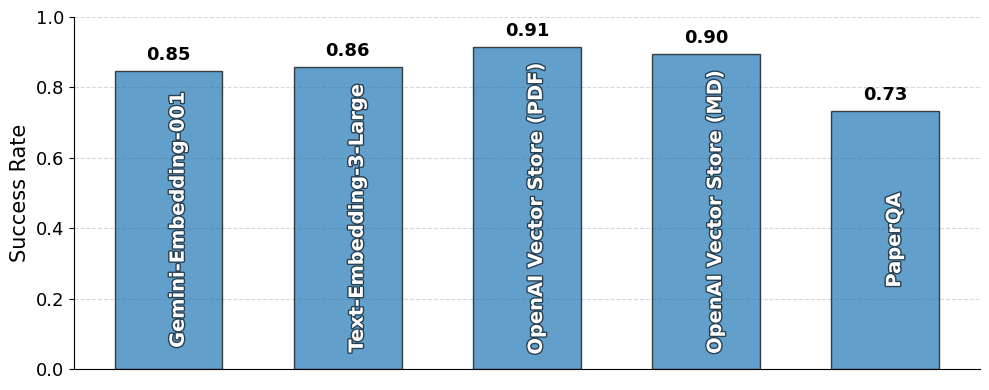

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as pe

labels = [
    'Gemini-Embedding-001',
    'Text-Embedding-3-Large',
    'OpenAI Vector Store (PDF)',
    'OpenAI Vector Store (MD)',
    'PaperQA'
]
scores = [0.8476, 0.8571, 0.9143, 0.8952, 0.7333]
colors = ['#96c5f7', '#b9e769', '#ffb347', '#ff6961', '#a393eb']

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(range(len(labels)), scores, alpha=0.7,#color=colors, 
              edgecolor='k', width=0.6, zorder=3)

# Add the category labels INSIDE the bars
for i, (bar, label) in enumerate(zip(bars, labels)):
    height = bar.get_height()
    facecolor = bar.get_facecolor()
    # Compute luminance for text color
    luminance = 0.299 * facecolor[0] + 0.587 * facecolor[1] + 0.114 * facecolor[2]
    text_color = 'black' if luminance > 0.6 else 'white'
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height*0.5,  # Adjust vertical position as needed
        label,
        ha='center',
        va='top',
        fontsize=14,
        fontweight='bold',
        color=text_color,
        rotation=90,  # Rotates the label vertically inside the bar
        wrap=True,
        path_effects=[pe.withStroke(linewidth=2, foreground='white' if text_color == 'black' else 'black', alpha=0.6)]
    )
    # Optionally, add the score at the top
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f'{scores[i]:.2f}',
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold',
        color='black'
    )

ax.set_ylabel('Success Rate', fontsize=15)
ax.set_ylim(0, 1.0)
# ax.set_title('Model Success Scores', fontsize=16, weight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', bottom=False, labelbottom=False)  # Hide x-axis ticks/labels
ax.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(bottom=-0.8)  # <-- add more space at the bottom
plt.tight_layout()
plt.savefig(results_path/"results.pdf")
plt.show()
